In [7]:
# checks if the montecarlo simulation generates the same distribution as a manufactured event log

import pm4py
from pm4py import write_xes as xes
from pm4py.objects.log.obj import EventLog, Trace
from datetime import datetime, timedelta
import numpy as np
import pm4py.algo.simulation.montecarlo as monte
from pm4py.algo.simulation.montecarlo import algorithm as montecarlo_simulation
from pm4py.algo.conformance.tokenreplay.algorithm import Variants
import pandas as pd
import random

random.seed(2023)
np.random.seed(2023)

In [8]:
# Function to generate timestamps based on an exponential distribution
def generate_timestamps(num_events, lambda_value):
    #timestamps = [timedelta(seconds=np.random.exponential(1/lambda_value)) for _ in range(num_events)]
    timestamps = [timedelta(seconds=np.random.exponential(1/lambda_value)) for _ in range(num_events)]
    return timestamps

# Generate event names and timestamps based on the exponential distribution
event_names = ["event b", "event c", "event d"]  # Example event names
num_events = 10000  # Number of events to generate
lambda_value = 0.1  # Lambda value for exponential distribution

timestamps = generate_timestamps(num_events, lambda_value)

# Create a synthetic event log
a=1
log = EventLog()
trace = Trace()
trace.attributes["concept:name"] = str(a)

current_time = datetime(2023, 1, 1)
k=0

prev_name=''
for i in range(num_events):
    current_time += timestamps[i]

    name = np.random.choice(event_names)
    while prev_name==name:
        name = np.random.choice(event_names)

    event = {
        'concept:name': name,
        'time:timestamp': pd.Timestamp(current_time),
        'Activity': name
    }

    if k==0:
        name = 'event a'
        event = {
        'concept:name': name,
        'time:timestamp': pd.Timestamp(current_time),
        'Activity': name
    }
        
    if k==8:
        name = "decide"
        event = {
        'concept:name': name,
        'time:timestamp': pd.Timestamp(current_time),
        'Activity': name
    }
        
    if k==9:
        name = np.random.choice(["event e", "event f"])
        event = {
        'concept:name': name,
        'time:timestamp': pd.Timestamp(current_time),
        'Activity': name
    }
    trace.insert(k, event)
    k=k+1

    if k == 10:
        a = a+1
        log.append(trace)
        trace = Trace()
        trace.attributes["concept:name"] = str(a)
        k=0
    prev_name = name

pm4py.write_xes(log, "/Users/ethanjohnson/Desktop/mphil-project/testing.xes")


dfg_perf, sa, ea = pm4py.discover_performance_dfg(log)
net, im, fm = pm4py.convert_to_petri_net(dfg_perf, sa, ea)



exporting log, completed traces :: 100%|██████████| 1000/1000 [00:00<00:00, 9318.03it/s]


In [9]:
# Extract timestamps from the event log
timestamps = []
for trace in log:
    for event in trace:
        timestamps.append(event['time:timestamp'])  # Assuming 'time:timestamp' is the timestamp attribute

# Calculate time differences (durations) between consecutive events
durations = []
for i in range(1, len(timestamps)):
    time_diff = timestamps[i] - timestamps[i - 1]
    durations.append(time_diff.total_seconds())

# Calculate statistics or analyze the durations
mean_duration = np.mean(durations)
median_duration = np.median(durations)
std_deviation = np.std(durations)

print(f"Mean Duration: {mean_duration} seconds")
print(f"Median Duration: {median_duration} seconds")
print(f"Standard Deviation: {std_deviation} seconds")



Mean Duration: 9.908336370537054 seconds
Median Duration: 6.944744 seconds
Standard Deviation: 9.853125124188841 seconds


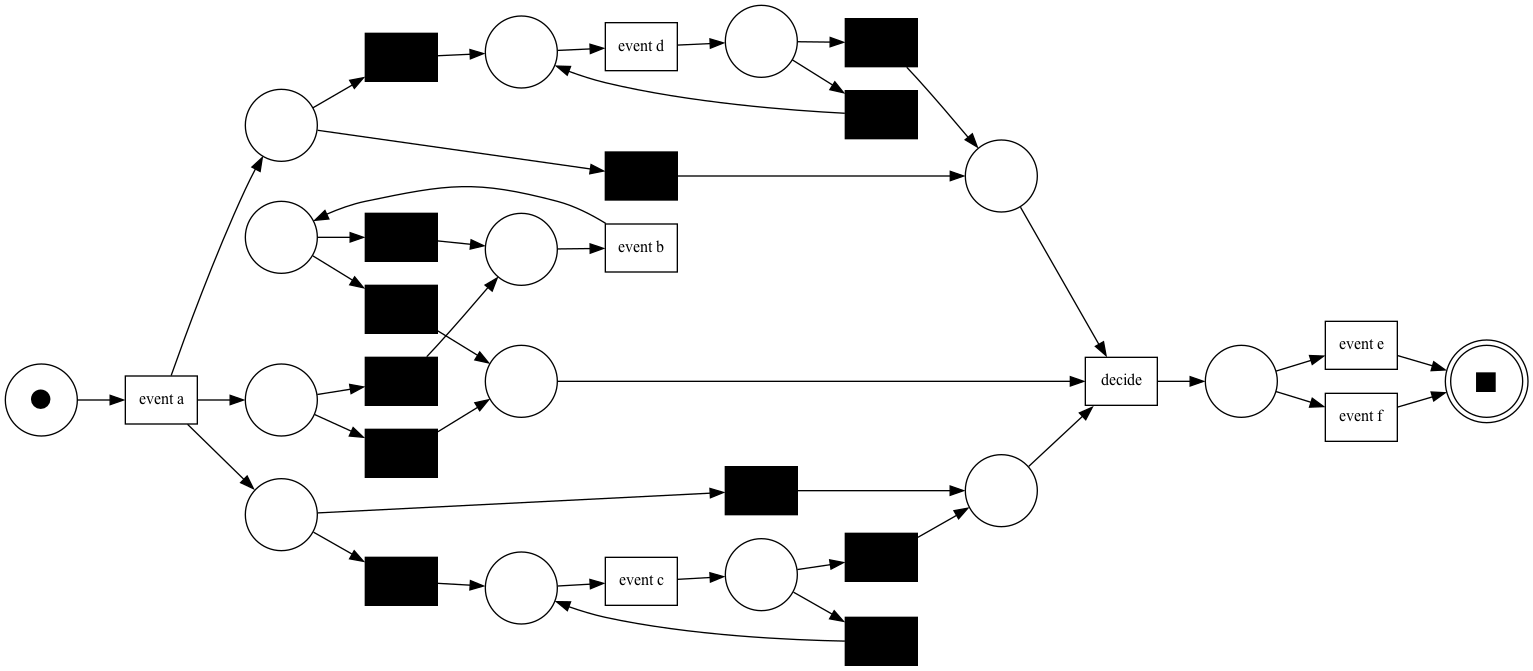

In [50]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer
net, im, fm = pm4py.discover_petri_net_inductive(log)

gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)

In [10]:

parameters={}
#montecarlo_simulation.Variants.PETRI_SEMAPH_FIFO.value.Parameters.TOKEN_REPLAY_VARIANT] = Variants.BACKWARDS
parameters[montecarlo_simulation.Variants.PETRI_SEMAPH_FIFO.value.Parameters.PARAM_MAX_THREAD_EXECUTION_TIME] = 1000
parameters[montecarlo_simulation.Variants.PETRI_SEMAPH_FIFO.value.Parameters.PARAM_MAP_RESOURCES_PER_PLACE] = {
    'event a': 1000,  # Assign 5 resources to 'place_1'
    'event b': 1000,  # Assign 10 resources to 'place_2'
    'event c': 1000,
    'event d': 1000,
    'decide': 1000,
    'event e': 1000,
    'event f': 1000
}

parameters[montecarlo_simulation.Variants.PETRI_SEMAPH_FIFO.value.Parameters.PARAM_NUM_SIMULATIONS] = 1000

simulated_log, res = montecarlo_simulation.apply(log, net, im, fm, parameters=parameters)

pm4py.write_xes(simulated_log, "/Users/ethanjohnson/Desktop/mphil-project/sim_testing.xes")



INFO:pm4py.algo.simulation.montecarlo.variants.petri_semaph_fifo:1701099558.32566 started the replay operation.
replaying log with TBR, completed variants :: 100%|██████████| 352/352 [00:00<00:00, 3164.56it/s]
/Users/ethanjohnson/.local/share/virtualenvs/mphil-project-KaAb4vnI/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
INFO:pm4py.algo.simulation.montecarlo.variants.petri_semaph_fifo:1701099560.1851149 ended the replay operation.
INFO:pm4py.algo.simulation.montecarlo.variants.petri_semaph_fifo:1701099560.188385 terminated successfully thread ID 0
INFO:pm4py.algo.simulation.montecarlo.variants.petri_semaph_fifo:1701099560.190686 terminated successfully thread ID 1
INFO:pm4py.algo.simulation.montecarlo.variants.petri_semaph_fifo:1701099560.190822 terminated successfully thread ID 2
INFO:pm4py.algo.simulation.montecarlo.variants.petri_semaph_fifo:1701099560.1931782

In [ ]:
log = pm4py.read_xes("/Users/ethanjohnson/Desktop/mphil-project/running-example.xes")

log = pm4py.convert_to_event_log(log)




dfg_perf, sa, ea = pm4py.discover_performance_dfg(log)
net, im, fm = pm4py.convert_to_petri_net(dfg_perf, sa, ea)

print(sa)
print(ea)
print(dfg_perf)



parsing log, completed traces :: 100%|██████████| 6/6 [00:00<00:00, 2079.82it/s]

{'register request': 6}
{'pay compensation': 3, 'reject request': 3}
Counter({('register request', 'examine casually'): {'median': 3840.0, 'min': 2040.0, 'max': 90840.0, 'stdev': 50757.06847326784, 'sum': 96720.0, 'mean': 32240.0}, ('examine casually', 'check ticket'): {'median': 48120.0, 'min': 5280.0, 'max': 90360.0, 'stdev': 47254.44740974123, 'sum': 191880.0, 'mean': 47970.0}, ('check ticket', 'decide'): {'median': 129300.0, 'min': 1800.0, 'max': 578640.0, 'stdev': 206034.11756308711, 'sum': 1091760.0, 'mean': 181960.0}, ('decide', 'reinitiate request'): {'median': 91800.0, 'min': 10800.0, 'max': 96600.0, 'stdev': 48210.78717465625, 'sum': 199200.0, 'mean': 66400.0}, ('reinitiate request', 'examine thoroughly'): {'median': 2880.0, 'min': 2880.0, 'max': 2880.0, 'stdev': 0, 'sum': 2880.0, 'mean': 2880.0}, ('examine thoroughly', 'check ticket'): {'median': 309090.0, 'min': 167820.0, 'max': 450360.0, 'stdev': 199785.94995644715, 'sum': 618180.0, 'mean': 309090.0}, ('decide', 'pay compe


/Users/ethanjohnson/.local/share/virtualenvs/mphil-project-KaAb4vnI/lib/python3.10/site-packages/pm4py/utils.py:537: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


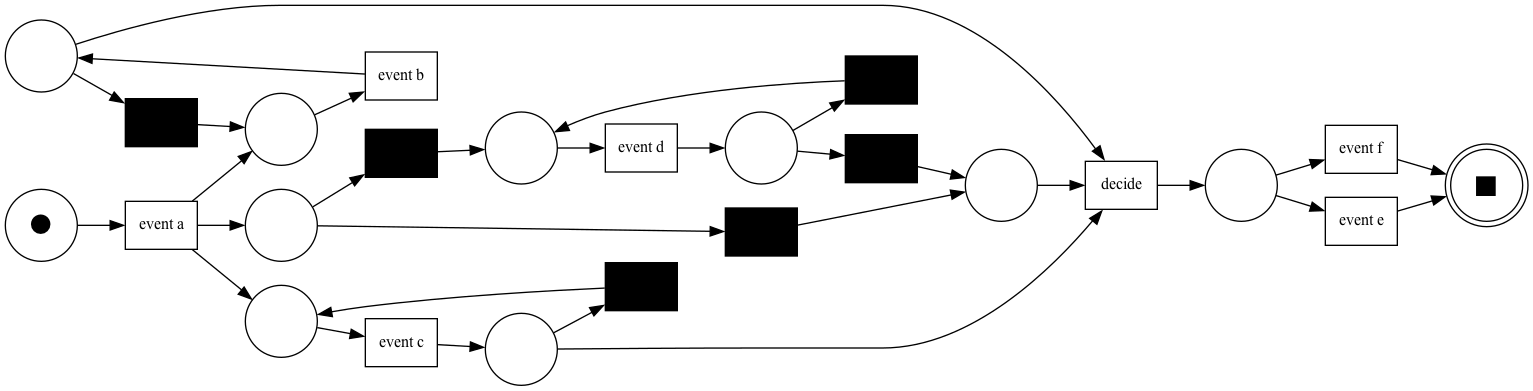

In [52]:
simnet, simim, simfm = pm4py.discover_petri_net_inductive(simulated_log)

gviz = pn_visualizer.apply(simnet, simim, simfm)
pn_visualizer.view(gviz)

In [11]:
timestamps = []
for trace in simulated_log:
    for event in trace:
        timestamps.append(event['time:timestamp'])  # Assuming 'time:timestamp' is the timestamp attribute

# Calculate time differences (durations) between consecutive events
durations = []
for i in range(1, len(timestamps)):
    time_diff = timestamps[i] - timestamps[i - 1]
    durations.append(time_diff.total_seconds())

mean_duration = np.mean(durations)
median_duration = np.median(durations)
std_deviation = np.std(durations)



print(f"Mean Duration sim: {mean_duration} seconds")
print(f"Median Duration sim: {median_duration} seconds")
print(f"Standard Deviation sim: {std_deviation} seconds")



Mean Duration sim: 9.99505834993948 seconds
Median Duration sim: 8.0704945 seconds
Standard Deviation sim: 7186.069485650906 seconds


Summary Statistics for Log 1 Time Differences:
count    9999.000000
mean        9.908336
std         9.853618
min         0.000062
25%         2.832696
50%         6.944744
75%        13.678515
max        98.802152
dtype: float64

Summary Statistics for Log 2 Time Differences:
count    9916.000000
mean        9.995058
std        17.814885
min         0.000000
25%         0.920952
50%         3.344103
75%         9.643527
max       133.991815
dtype: float64


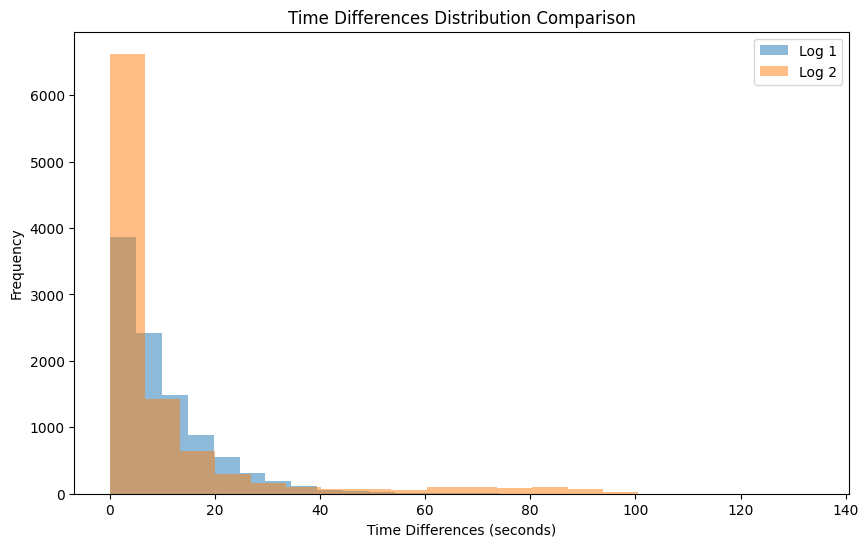

Kolmogorov-Smirnov Test p-value: 3.22481480723243e-206


In [12]:

from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

# Load event logs
log1 = log  # Replace 'log1.xes' with your file
log2 = simulated_log  # Replace 'log2.xes' with your file

# Extract timestamps from event logs
timestamps_log1 = [event['time:timestamp'] for trace in log1 for event in trace]
timestamps_log2 = [event['time:timestamp'] for trace in log2 for event in trace]

timestamps_log1.sort()
timestamps_log2.sort()

# Compute time differences
time_diff_log1 = [(timestamps_log1[i + 1] - timestamps_log1[i]).total_seconds()
                  for i in range(len(timestamps_log1) - 1)]
time_diff_log2 = [(timestamps_log2[i + 1] - timestamps_log2[i]).total_seconds()
                  for i in range(len(timestamps_log2) - 1)]



# Summary statistics
print("Summary Statistics for Log 1 Time Differences:")
print(pd.Series(time_diff_log1).describe())

print("\nSummary Statistics for Log 2 Time Differences:")
print(pd.Series(time_diff_log2).describe())

# Visualization - Histograms
plt.figure(figsize=(10, 6))
plt.hist(time_diff_log1, bins=20, alpha=0.5, label='Log 1')
plt.hist(time_diff_log2, bins=20, alpha=0.5, label='Log 2')
plt.legend()
plt.title('Time Differences Distribution Comparison')
plt.xlabel('Time Differences (seconds)')
plt.ylabel('Frequency')
plt.show()

# Statistical Test (Kolmogorov-Smirnov Test)
ks_stat, p_value = ks_2samp(time_diff_log1, time_diff_log2)
print(f"Kolmogorov-Smirnov Test p-value: {p_value}")
